In [23]:
import sys
import os
from collections import deque
import time
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [24]:
class PerceptronPyTorch(nn.Module):
    """
    Implements a perceptron for branch prediction using PyTorch.
    Attributes:
        N: Length of the branch history register.
    Methods:
        predict(branch_history): Predicts the branch outcome.
        update_weights(prediction, actual, branch_history, running_sum): Updates perceptron weights.
    """
    def __init__(self, N):
        super(PerceptronPyTorch, self).__init__()
        self.N = N
        self.linear = nn.Linear(N, 1, bias=True)
        nn.init.zeros_(self.linear.weight)
        nn.init.zeros_(self.linear.bias)
        self.threshold = 2 * N + 14

    def predict(self, branch_history):
        """
        Predicts the outcome of a branch based on the branch history.
        Parameters:
            branch_history (deque): A deque representing recent branch outcomes.
        Returns:
            prediction (int): Predicted branch outcome (-1 for not taken, 1 for taken).
            running_sum (float): The perceptron output value (confidence score).
        """
        input_tensor = torch.tensor(list(branch_history), dtype=torch.float32).unsqueeze(0)
        running_sum = self.linear(input_tensor).item()
        prediction = -1 if running_sum < 0 else 1
        return prediction, running_sum

    def update_weights(self, prediction, actual, branch_history, running_sum):
        """
        Updates perceptron weights if the prediction is incorrect or confidence is low.
        Parameters:
            prediction (int): Predicted branch outcome (-1 or 1).
            actual (int): Actual branch outcome (-1 or 1).
            branch_history (deque): Recent branch outcomes used as input.
            running_sum (float): The perceptron output value.
        """
        if (prediction != actual) or (abs(running_sum) < self.threshold):
            input_tensor = torch.tensor(list(branch_history), dtype=torch.float32).unsqueeze(0)
            actual_tensor = torch.tensor([actual], dtype=torch.float32)
            with torch.no_grad():
                self.linear.weight += actual_tensor * input_tensor
                self.linear.bias += actual_tensor

In [25]:
def perceptron_pred_pytorch(trace, l=1, tablesize=None):
    """
    Simulates branch prediction using perceptrons with a global branch history.
    Parameters:
        trace (list): List of [branch_address, outcome] pairs from the trace file.
        l (int): Length of the global branch history register.
        tablesize (int, optional): Maximum size of the perceptron table. Defaults to None (unlimited size).
    Returns:
        num_correct (int): Number of correct predictions.
        len(p_list) (int): Number of perceptron instances created.
    """
    global_branch_history = deque([0] * l, maxlen=l)  
    p_list = {}  
    num_correct = 0  

    for br in trace:
        branch_address = br[0]
        outcome = 1 if br[1] else -1

        if tablesize:
            index = hash(branch_address) % tablesize
            key = index
        else:
            key = branch_address

        if key not in p_list:
            p_list[key] = PerceptronPyTorch(l)

        prediction, running_sum = p_list[key].predict(global_branch_history)

        p_list[key].update_weights(prediction, outcome, global_branch_history, running_sum)

        global_branch_history.appendleft(outcome)

        if prediction == outcome:
            num_correct += 1

    return num_correct, len(p_list)  


In [26]:
def getTableSize(ratio,k):
    return int(ratio * k)

In [27]:
def read_trace_from_file(file_path):
    """
    Reads a branch trace file and parses branch addresses and outcomes.
    Parameters:
        file_path (str): Path to the branch trace file.
    Returns:
        trace (list): A list of [branch_address, outcome] pairs.
    """
    trace = []
    try:
        with open(file_path, 'r') as file:
            for line_number, line in enumerate(file, start=1):
                line = line.strip()
                if not line:
                    continue
                parts = line.split()
                if len(parts) != 2:
                    print(f"Warning: Line {line_number} is malformed: '{line}'")
                    continue
                branch_address, outcome_str = parts
                try:
                    outcome = int(outcome_str)
                    if outcome not in (0, 1):
                        print(f"Warning: Line {line_number} has invalid outcome '{outcome}': '{line}'")
                        continue
                except ValueError:
                    print(f"Warning: Line {line_number} has non-integer outcome '{outcome_str}': '{line}'")
                    continue
                trace.append([branch_address, outcome])
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
    except IOError as e:
        print(f"IOError while reading file '{file_path}': {e}")
    return trace

In [30]:
def process_trace(file_path, max_l):
    """
    Process a single trace file, run the perceptron predictor for different l values,
    and return the results as lists.
    """
    trace = read_trace_from_file(file_path)
    print(f"Processing {file_path}")
    print(f"Total branches in trace: {len(trace)}\n")
    
    if len(trace) == 0:
        print("No valid branch data found. Skipping this dataset.")
        return None, None, None

    l_values = []
    accuracies = []
    times = []

    for i in range(1, max_l + 1):
        start_time = time.time()
        num_correct, num_p = perceptron_pred_pytorch(trace, l=i, tablesize=None)
        end_time = time.time()
        duration = end_time - start_time
        accuracy = (num_correct / len(trace)) * 100 if len(trace) > 0 else 0

        l_values.append(i)
        accuracies.append(accuracy)
        times.append(duration)

        print(f"i:{i} --> (Accuracy: {accuracy:.2f}%, Time: {duration:.4f} seconds)")

    return l_values, accuracies, times


def main():
    """
    Main function to process multiple datasets and plot results.
    """
    file_paths = [
        r'C:\Users\prato\OneDrive\Desktop\EECE7205 - Fundamentals of CompE\Project\Trace files\factorial.txt',
        r'C:\Users\prato\OneDrive\Desktop\EECE7205 - Fundamentals of CompE\Project\Trace files\fibonacci.txt',
        r'C:\Users\prato\OneDrive\Desktop\EECE7205 - Fundamentals of CompE\Project\Trace files\insertionsort.txt',
        r'C:\Users\prato\OneDrive\Desktop\EECE7205 - Fundamentals of CompE\Project\Trace files\mergesort.txt',
        r'C:\Users\prato\OneDrive\Desktop\EECE7205 - Fundamentals of CompE\Project\Trace files\prime.txt',
        r'C:\Users\prato\OneDrive\Desktop\EECE7205 - Fundamentals of CompE\Project\Trace files\quicksort.txt'
    ]

    max_l = 50  # Maximum value of l to test
    results = {}

    # Process each dataset
    for file_path in file_paths:
        dataset_name = file_path.split('\\')[-1].split('.')[0]
        l_values, accuracies, times = process_trace(file_path, max_l)
        if l_values:
            results[dataset_name] = {
                'l_values': l_values,
                'accuracies': accuracies,
                'times': times
            }

    # Plot accuracy comparisons
    plt.figure(figsize=(12, 8))
    for dataset_name, data in results.items():
        plt.plot(data['l_values'], data['accuracies'], marker='o', label=f'{dataset_name} Accuracy')
    plt.title('Accuracy vs. Branch History Length for Multiple Datasets')
    plt.xlabel('Branch History Length')
    plt.ylabel('Accuracy (%)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.show()



Processing C:\Users\prato\OneDrive\Desktop\EECE7205 - Fundamentals of CompE\Project\Trace files\factorial.txt
Total branches in trace: 31781

i:1 --> (Accuracy: 88.74%, Time: 1.2922 seconds)
i:2 --> (Accuracy: 89.06%, Time: 0.9153 seconds)
i:3 --> (Accuracy: 88.94%, Time: 0.8746 seconds)
i:4 --> (Accuracy: 89.06%, Time: 1.0304 seconds)
i:5 --> (Accuracy: 89.32%, Time: 0.8801 seconds)
i:6 --> (Accuracy: 89.31%, Time: 2.4663 seconds)
i:7 --> (Accuracy: 89.35%, Time: 4.2536 seconds)
i:8 --> (Accuracy: 89.49%, Time: 5.1820 seconds)
i:9 --> (Accuracy: 89.44%, Time: 1.0278 seconds)
i:10 --> (Accuracy: 89.48%, Time: 0.8105 seconds)
i:11 --> (Accuracy: 89.43%, Time: 1.0383 seconds)
i:12 --> (Accuracy: 89.38%, Time: 0.9996 seconds)
i:13 --> (Accuracy: 89.32%, Time: 0.9412 seconds)
i:14 --> (Accuracy: 89.37%, Time: 0.8907 seconds)
i:15 --> (Accuracy: 89.26%, Time: 0.9879 seconds)
i:16 --> (Accuracy: 89.25%, Time: 0.9618 seconds)
i:17 --> (Accuracy: 89.21%, Time: 2.1404 seconds)
i:18 --> (Accurac

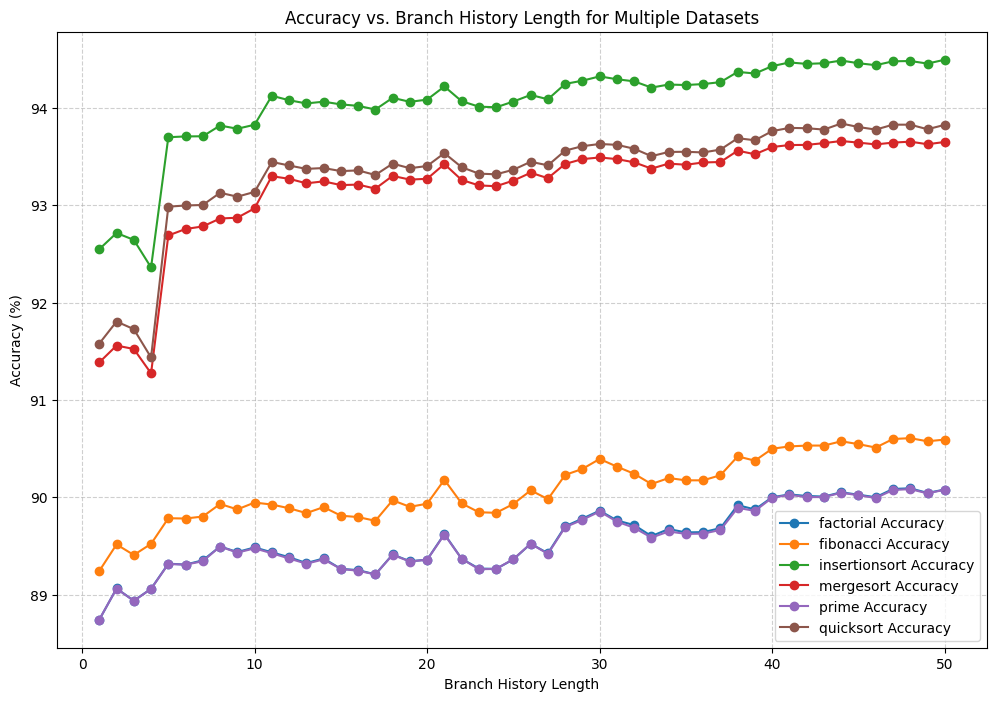

: 

In [ ]:
if __name__ == "__main__":
    main()